# LowCarb thorax disease classification in Flower

## Check GPU availability

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 23 16:09:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create dirs, get data 

In [1]:
!mkdir NIH
!mkdir /root/.kaggle/

### Copy Kaggle API-key to created directory at '/root/.kaggle'

In [2]:
!cp '/content/drive/MyDrive/professional/Research_Jobs/UMI/projects/APIs/kaggle.json' '/root/.kaggle'

In [3]:
!kaggle datasets download -d nih-chest-xrays/data

100% 42.0G/42.0G [12:20<00:00, 72.3MB/s]
100% 42.0G/42.0G [12:20<00:00, 60.9MB/s]


In [4]:
!unzip -q '/content/data.zip' -d '/content/NIH/'

## Install packages

In [5]:
!pip install flwr[simulation]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 8.8 MB/s 
     |████████████████████████████████| 1.0 MB 93.8 MB/s 
     |████████████████████████████████| 54.5 MB 1.2 MB/s 
     |████████████████████████████████| 4.1 MB 57.6 MB/s 
     |████████████████████████████████| 8.8 MB 63.0 MB/s 
     |████████████████████████████████| 201 kB 96.1 MB/s 
     |████████████████████████████████| 3.0 MB 86.9 MB/s 
     |████████████████████████████████| 57 kB 5.6 MB/s 
     |████████████████████████████████| 128 kB 94.6 MB/s 
     |████████████████████████████████| 90 kB 11.3 MB/s 
     |████████████████████████████████| 291 kB 96.2 MB/s 
     |████████████████████████████████| 58 kB 7.1 MB/s 
     |████████████████████████████████| 468 kB 70.3 MB/s 
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19889 sha256=c880d657db33da6e2df75413c063354a0148eb81155c8e4a10ae142c785fc8be
  

## Imports

In [6]:
import os
import sys
import math
import time
from glob import glob
from PIL import Image
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## Data

### Preprocess

In [7]:
root_img_dir = '/content/NIH/'

In [8]:
all_xray_df = pd.read_csv(
    os.path.join(
        root_img_dir,
        'Data_Entry_2017.csv'
        )
    )

all_image_paths = {
    os.path.basename(x): x for x in 
    glob(os.path.join(root_img_dir, 'images*', '*', '*.png'))
    }

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
61200,00015087_005.png,No Finding,5,15087,66,M,AP,2500,2048,0.168,0.168,NaN,/content/NIH/images_007/images/00015087_005.png
51829,00013089_004.png,Consolidation|Effusion|Infiltration,4,13089,50,M,PA,2992,2991,0.143,0.143,NaN,/content/NIH/images_006/images/00013089_004.png
13832,00003568_001.png,Infiltration,1,3568,62,M,PA,2992,2991,0.143,0.143,NaN,/content/NIH/images_002/images/00003568_001.png


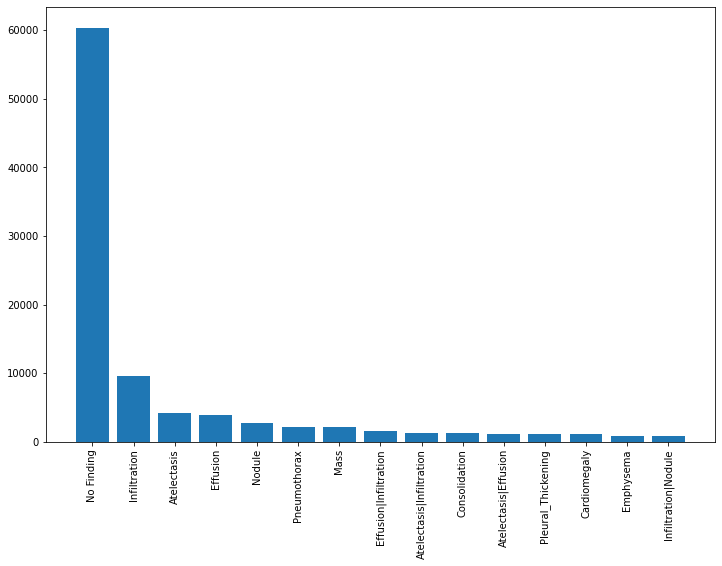

In [9]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [10]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
62350,00015425_000.png,,0,15425,50,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28243,00007354_015.png,Infiltration,15,7354,43,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
57958,00014352_000.png,,0,14352,5,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [
    c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES
    ]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


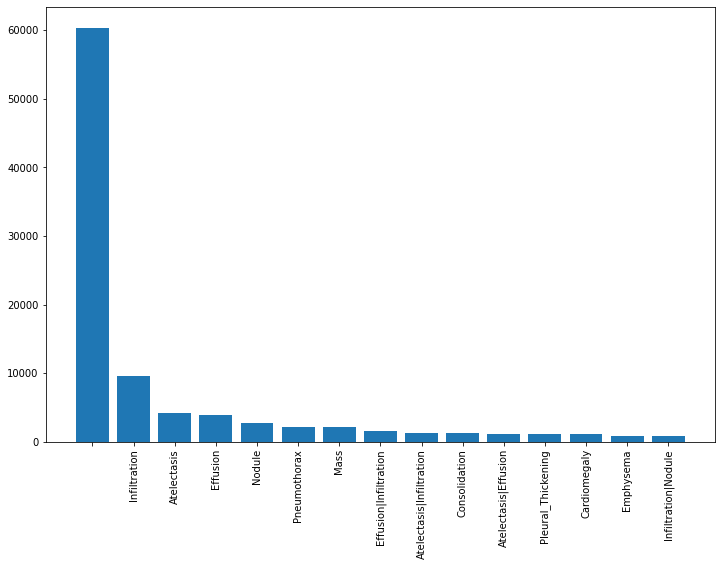

In [12]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()

all_xray_df = all_xray_df.sample(112120, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

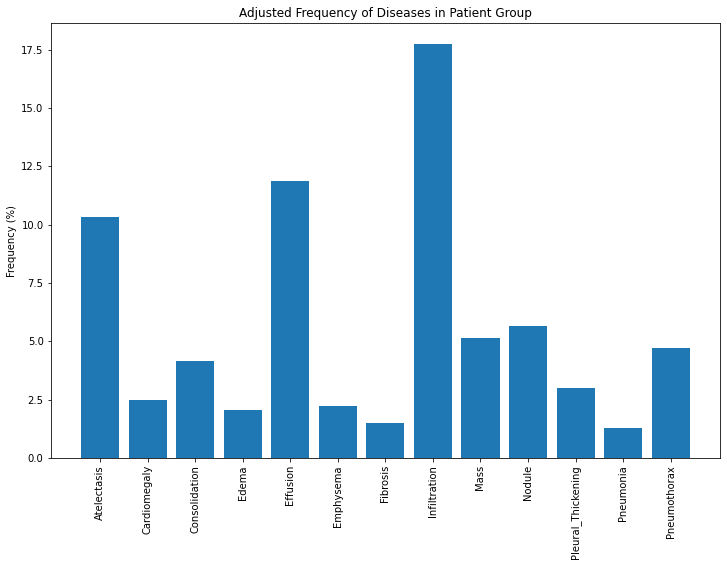

In [13]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [14]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
14008,00003617_000.png,,0,3617,70,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
38720,00010104_000.png,Atelectasis,0,10104,70,M,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
94413,00024186_000.png,,0,24186,30,F,PA,2210,2608,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [15]:
len(all_xray_df)

112120

### Get DataLoaders

In [16]:
class NIH_Dataset(Dataset):
  def __init__(
    self, 
    data_df,
    transform=None
    ):
    self.data_df = data_df
    self.transform = transform 

  def __len__(
    self
    ):
    return len(self.data_df)

  def __getitem__(
    self, 
    idx
    ):
    img_file = self.data_df['path'].iloc[idx]
    img = Image.open(img_file).convert('RGB')
    label = np.array(self.data_df.iloc[:,-1].iloc[idx], dtype=float)
    if self.transform:
        img = self.transform(img)

    return img, label

def get_data_loaders(
    data_df: pd.DataFrame,
    global_train_frac: float = 0.8,
    local_train_frac: float = 0.8,
    batch_size: int = 32,
    num_clients: int = 10
    ):
  train_data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    # T.Resize((512,512)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])

  test_data_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])
  
  train_df, test_df = train_test_split(
      data_df,
      test_size = 1 - global_train_frac,
      random_state = 42,
      stratify = data_df['Finding Labels'].map( lambda x: x[:4])
  )

  trainset = NIH_Dataset(
      train_df,
      transform = train_data_transform
      )
  
  testset = NIH_Dataset(
      test_df,
      transform = test_data_transform
      )

  # Split training set into `num_clients` partitions to simulate different local datasets
  partition_size = len(trainset) // num_clients
  lengths = [partition_size] * num_clients
  lengths[-1] += len(trainset) - np.sum(lengths)
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:      
      len_train = math.ceil(len(ds) * local_train_frac)
      len_val = len(ds) - math.ceil(len(ds) * local_train_frac)
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last = True))
      valloaders.append(DataLoader(ds_val, batch_size=batch_size, drop_last = True))
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainloaders, valloaders, testloader

def inv_data_transform(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

In [17]:
num_clients = 100

trainloaders, valloaders, testloader = get_data_loaders(
    all_xray_df,
    global_train_frac = 0.95,
    local_train_frac = 0.9,
    num_clients = num_clients,
    batch_size = 25
)

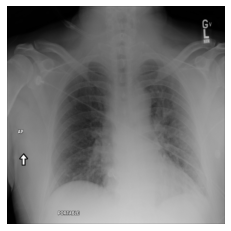

In [18]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [19]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset)

(959, 106, 5607)

In [20]:
len(all_labels)

13

### FL utils basic

In [21]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### FL training utils

In [23]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon = 1e-7):
    y_pred = torch.sigmoid(y_pred)
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def train(
    net,
    trainloader,
    epochs
    ):
    print(f'Entered train function, total num. of epochs: {epochs}')
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    valid_loss_min = np.Inf
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = 1e-4
        )
    start_time = time.time()
    for i in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 
        net.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            ps = net(images)
            
            loss = weighted_loss(pos_weights, neg_weights, ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)
        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    end_time = time.time()
    time_delta = end_time - start_time
    print('\n')
    print(f'Time to complete local training round: {time_delta}')
    print('\n')

def test(net, testloader, pathology_list):
    
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset)) * 100.0 for i in per_class_accuracy]

    return loss, np.mean(per_class_accuracy)

def get_acc_data(
    class_names,
    acc_list
    ):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Class Acc.']) 
    return df

In [24]:
def server_eval(
    server_round: int,
    parameters: fl.common.NDArrays, 
    config: Dict[str, fl.common.Scalar]
    ):
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    net = init_net().to(DEVICE)

    set_parameters(net, parameters)  # Update model with the latest parameters

    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
          
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            ps = torch.sigmoid(ps)
            ps = (ps >= 0.5).float()
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset))*100.0 for i in per_class_accuracy]

    test_df = get_acc_data(all_labels, per_class_accuracy)
    print('\nServer eval')
    print(test_df)
    print('\n')

    return loss,  {"mean_class_acc.": np.mean(per_class_accuracy)}

## Training

In [26]:
def init_net():
  net = models.vgg11(
    #weights="IMAGENET1K_V1"
    weights=None
  )
  net.classifier[-1] = torch.nn.Linear(
      net.classifier[-1].in_features,
      len(all_labels)
  )
  return net

def client_fn(cid) -> FlowerClient:
    net = init_net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    print(f'Created client: {cid}')
    return FlowerClient(cid, net, trainloader, valloader)

### 35 local epochs take approx 15min. on A100 for each client and 30 local epochs on Tesla T4 

Need to fix freeing GPU space after instances have been created and trained

In [27]:
num_rounds = 10
local_epochs = 30
fraction_fit = 0.05
fraction_evaluate = 0.05
min_fit_clients = 4
min_evaluate_clients = 4

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

INFO flower 2022-10-24 11:50:11,003 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2022-10-24 11:50:13,943 | app.py:179 | Flower VCE: Ray initialized with resources: {'node:172.28.0.2': 1.0, 'object_store_memory': 16336975872.0, 'CPU': 8.0, 'memory': 32673951744.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'node:172.28.0.2': 1.0, 'object_store_memory': 16336975872.0, 'CPU': 8.0, 'memory': 32673951744.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0}
INFO flower 2022-10-24 11:50:13,947 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-24 11:50:13,949 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-24 11:50:13,952 | server.py:88 | 


Server eval
                Labels  Class Acc.
0          Atelectasis   32.405921
1         Cardiomegaly   24.451578
2        Consolidation   21.187801
3                Edema   24.933119
4             Effusion   73.301231
5            Emphysema   88.781880
6             Fibrosis   42.375602
7         Infiltration   25.378991
8                 Mass   30.622436
9               Nodule   50.312110
10  Pleural_Thickening   71.214553
11           Pneumonia   64.455145
12        Pneumothorax   44.997325


(launch_and_fit pid=1014) Created client: 78
(launch_and_fit pid=1014) [Client 78, round 1] fit, config: {'server_round': 1, 'local_epochs': 30}
(launch_and_fit pid=1014) Entered train function, total num. of epochs: 30
(launch_and_fit pid=1014) Epoch : 1 Train Loss : 0.912508 
(launch_and_fit pid=1014) Epoch : 2 Train Loss : 0.908310 
(launch_and_fit pid=1014) Epoch : 3 Train Loss : 0.907050 
(launch_and_fit pid=1014) Epoch : 4 Train Loss : 0.900064 
(launch_and_fit pid=1014) Epoch : 5 Tra

DEBUG flower 2022-10-24 12:09:47,777 | server.py:234 | fit_round 1 received 1 results and 4 failures
DEBUG:flower:fit_round 1 received 1 results and 4 failures
WARNING flower 2022-10-24 12:09:49,322 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-24 12:13:26,632 | server.py:122 | fit progress: (1, tensor(211.2333, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 62.424716357300625}, 1157.9459878890002)
INFO:flower:fit progress: (1, tensor(211.2333, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 62.424716357300625}, 1157.9459878890002)
DEBUG flower 2022-10-24 12:13:26,638 | server.py:170 | evaluate_round 1: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 1: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   36.525771
1         Cardiomegaly   94.667380
2        Consolidation   73.657928
3                Edema   75.031211
4             Effusion   77.884787
5            Emphysema   22.810772
6             Fibrosis   50.008917
7         Infiltration   58.159444
8                 Mass   53.433208
9               Nodule   84.055645
10  Pleural_Thickening   84.162654
11           Pneumonia   76.529338
12        Pneumothorax   24.594257


(launch_and_evaluate pid=1776) Created client: 59
(launch_and_evaluate pid=1776) [Client 59] evaluate, config: {}


(launch_and_fit pid=1360) E1024 12:13:56.251425536    1388 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=1812) Created client: 24


DEBUG flower 2022-10-24 12:14:01,891 | server.py:184 | evaluate_round 1 received 0 results and 5 failures
DEBUG:flower:evaluate_round 1 received 0 results and 5 failures
DEBUG flower 2022-10-24 12:14:01,893 | server.py:220 | fit_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 2: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=1812) [Client 24] evaluate, config: {}


(launch_and_fit pid=1393) E1024 12:14:10.314643310    1422 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=1950) Created client: 26
(launch_and_fit pid=1950) [Client 26, round 2] fit, config: {'server_round': 2, 'local_epochs': 30}
(launch_and_fit pid=1950) Entered train function, total num. of epochs: 30
(launch_and_fit pid=1950) Epoch : 1 Train Loss : 0.918508 
(launch_and_fit pid=1950) Epoch : 2 Train Loss : 0.876585 
(launch_and_fit pid=1950) Epoch : 3 Train Loss : 0.861924 
(launch_and_fit pid=1950) Epoch : 4 Train Loss : 0.840689 
(launch_and_fit pid=1950) Epoch : 5 Train Loss : 0.810663 
(launch_and_fit pid=1950) Epoch : 6 Train Loss : 0.792319 
(launch_and_fit pid=1950) Epoch : 7 Train Loss : 0.769133 
(launch_and_fit pid=1950) Epoch : 8 Train Loss : 0.721234 
(launch_and_fit pid=1950) Epoch : 9 Train Loss : 0.705678 
(launch_and_fit pid=1950) Epoch : 10 Train Loss : 0.659366 
(launch_and_fit pid=1950) Epoch : 11 Train Loss : 0.628020 
(launch_and_fit pid=1950) Epoch : 12 Train Loss : 0.575946 
(launch_and_fit pid=1950) Epoch : 13 Train Loss : 0.560268 
(launch_a

DEBUG flower 2022-10-24 12:29:52,802 | server.py:234 | fit_round 2 received 1 results and 4 failures
DEBUG:flower:fit_round 2 received 1 results and 4 failures
INFO flower 2022-10-24 12:33:29,329 | server.py:122 | fit progress: (2, tensor(203.0044, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.34223703886626}, 2360.6428603040004)
INFO:flower:fit progress: (2, tensor(203.0044, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.34223703886626}, 2360.6428603040004)
DEBUG flower 2022-10-24 12:33:29,334 | server.py:170 | evaluate_round 2: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 2: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.602283
1         Cardiomegaly   96.968076
2        Consolidation   95.808810
3                Edema   97.931157
4             Effusion   88.282504
5            Emphysema   97.627965
6             Fibrosis   98.608882
7         Infiltration   81.933298
8                 Mass   94.970572
9               Nodule   94.328518
10  Pleural_Thickening   96.343856
11           Pneumonia   98.858570
12        Pneumothorax   95.184591


(launch_and_evaluate pid=2644) Created client: 82
(launch_and_evaluate pid=2644) [Client 82] evaluate, config: {}
(launch_and_evaluate pid=2680) Created client: 80
(launch_and_evaluate pid=2680) [Client 80] evaluate, config: {}
(launch_and_evaluate pid=2715) Created client: 62
(launch_and_evaluate pid=2715) [Client 62] evaluate, config: {}


(launch_and_fit pid=2297) E1024 12:34:01.451563374    2325 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=2750) Created client: 48


DEBUG flower 2022-10-24 12:34:07,101 | server.py:184 | evaluate_round 2 received 0 results and 5 failures
DEBUG:flower:evaluate_round 2 received 0 results and 5 failures
DEBUG flower 2022-10-24 12:34:07,105 | server.py:220 | fit_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 3: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=2750) [Client 48] evaluate, config: {}


(launch_and_fit pid=2330) E1024 12:34:16.423892338    2358 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=2885) Created client: 18
(launch_and_fit pid=2885) [Client 18, round 3] fit, config: {'server_round': 3, 'local_epochs': 30}
(launch_and_fit pid=2885) Entered train function, total num. of epochs: 30


(launch_and_fit pid=2363) E1024 12:34:25.503411778    2391 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=2396) E1024 12:34:29.860099118    2424 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=3054) Created client: 16
(launch_and_fit pid=3054) [Client 16, round 3] fit, config: {'server_round': 3, 'local_epochs': 30}
(launch_and_fit pid=3054) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 12:34:44,833 | server.py:234 | fit_round 3 received 0 results and 5 failures
DEBUG:flower:fit_round 3 received 0 results and 5 failures
INFO flower 2022-10-24 12:38:19,756 | server.py:122 | fit progress: (3, tensor(202.9816, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3353774814449}, 2651.0701764800006)
INFO:flower:fit progress: (3, tensor(202.9816, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3353774814449}, 2651.0701764800006)
DEBUG flower 2022-10-24 12:38:19,761 | server.py:170 | evaluate_round 3: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 3: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.620118
1         Cardiomegaly   96.754057
2        Consolidation   95.808810
3                Edema   97.913323
4             Effusion   88.282504
5            Emphysema   97.627965
6             Fibrosis   98.608882
7         Infiltration   82.129481
8                 Mass   94.970572
9               Nodule   94.310683
10  Pleural_Thickening   96.308186
11           Pneumonia   98.858570
12        Pneumothorax   95.166756




(launch_and_evaluate pid=2680) E1024 12:38:27.595425241    2708 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=3211) Created client: 76
(launch_and_evaluate pid=3211) [Client 76] evaluate, config: {}


(launch_and_evaluate pid=2715) E1024 12:38:34.250468142    2743 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=3308) Created client: 70
(launch_and_evaluate pid=3308) [Client 70] evaluate, config: {}


(launch_and_evaluate pid=2750) E1024 12:38:40.742754189    2778 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=3344) Created client: 29
(launch_and_evaluate pid=3344) [Client 29] evaluate, config: {}


(launch_and_fit pid=2885) E1024 12:38:47.219778517    2935 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=3380) Created client: 7
(launch_and_evaluate pid=3380) [Client 7] evaluate, config: {}


(launch_and_fit pid=2953) E1024 12:38:53.777898989    2981 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=3417) Created client: 59


DEBUG flower 2022-10-24 12:38:59,257 | server.py:184 | evaluate_round 3 received 0 results and 5 failures
DEBUG:flower:evaluate_round 3 received 0 results and 5 failures
DEBUG flower 2022-10-24 12:38:59,260 | server.py:220 | fit_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 4: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=3417) [Client 59] evaluate, config: {}


(launch_and_fit pid=2987) E1024 12:39:07.389618952    3015 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=3021) E1024 12:39:13.376522323    3049 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(scheduler +58m2s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +58m2s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


(launch_and_fit pid=3054) E1024 12:39:17.746357365    3082 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=3649) Created client: 53
(launch_and_fit pid=3649) [Client 53, round 4] fit, config: {'server_round': 4, 'local_epochs': 30}
(launch_and_fit pid=3649) Entered train function, total num. of epochs: 30
(launch_and_fit pid=3687) Created client: 74
(launch_and_fit pid=3687) [Client 74, round 4] fit, config: {'server_round': 4, 'local_epochs': 30}
(launch_and_fit pid=3687) Entered train function, total num. of epochs: 30
(launch_and_fit pid=3723) Created client: 4
(launch_and_fit pid=3723) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 30}
(launch_and_fit pid=3723) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 12:39:38,449 | server.py:234 | fit_round 4 received 0 results and 5 failures
DEBUG:flower:fit_round 4 received 0 results and 5 failures
INFO flower 2022-10-24 12:43:13,253 | server.py:122 | fit progress: (4, tensor(202.8920, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.35458424222469}, 2944.567448404)
INFO:flower:fit progress: (4, tensor(202.8920, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.35458424222469}, 2944.567448404)
DEBUG flower 2022-10-24 12:43:13,258 | server.py:170 | evaluate_round 4: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 4: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.637953
1         Cardiomegaly   96.932406
2        Consolidation   95.808810
3                Edema   97.931157
4             Effusion   88.282504
5            Emphysema   97.610130
6             Fibrosis   98.608882
7         Infiltration   82.236490
8                 Mass   94.988407
9               Nodule   94.328518
10  Pleural_Thickening   96.254682
11           Pneumonia   98.858570
12        Pneumothorax   95.131086




(launch_and_evaluate pid=3344) E1024 12:43:22.152022228    3372 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=3878) Created client: 10
(launch_and_evaluate pid=3878) [Client 10] evaluate, config: {}


(launch_and_evaluate pid=3380) E1024 12:43:28.539023937    3409 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=3975) Created client: 32
(launch_and_evaluate pid=3975) [Client 32] evaluate, config: {}


(launch_and_evaluate pid=3417) E1024 12:43:34.896148204    3445 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=4011) Created client: 45
(launch_and_evaluate pid=4011) [Client 45] evaluate, config: {}


(launch_and_fit pid=3531) E1024 12:43:41.249956930    3608 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=3614) E1024 12:43:47.267394011    3642 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
DEBUG flower 2022-10-24 12:43:50,808 | server.py:184 | evaluate_round 4 received 0 results and 5 failures
DEBUG:flower:evaluate_round 4 received 0 results and 5 failures
DEBUG flower 2022-10-24 12:43:50,813 | server.py:220 | fit_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 5: strategy sampled 5 clients (out of 100)
(launch_and_fit pid=3649) E1024 12:43:57.865126694    3678 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=4145) Created client: 64
(launch_and_fit pid=4145) [Client 64, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=4145) Entered train function, total num. of epochs: 30


(launch_and_fit pid=3687) E1024 12:44:05.071406846    3715 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=4279) Created client: 85
(launch_and_fit pid=4279) [Client 85, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=4279) Entered train function, total num. of epochs: 30


(launch_and_fit pid=3723) E1024 12:44:12.711315114    3751 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=4316) Created client: 65
(launch_and_fit pid=4316) [Client 65, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=4316) Entered train function, total num. of epochs: 30
(launch_and_fit pid=4354) Created client: 3
(launch_and_fit pid=4354) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=4354) Entered train function, total num. of epochs: 30
(launch_and_fit pid=4392) Created client: 93
(launch_and_fit pid=4392) [Client 93, round 5] fit, config: {'server_round': 5, 'local_epochs': 30}
(launch_and_fit pid=4392) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 12:44:33,660 | server.py:234 | fit_round 5 received 0 results and 5 failures
DEBUG:flower:fit_round 5 received 0 results and 5 failures
INFO flower 2022-10-24 12:48:07,916 | server.py:122 | fit progress: (5, tensor(202.9999, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.33674939292915}, 3239.2305244199997)
INFO:flower:fit progress: (5, tensor(202.9999, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.33674939292915}, 3239.2305244199997)
DEBUG flower 2022-10-24 12:48:07,922 | server.py:170 | evaluate_round 5: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 5: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.602283
1         Cardiomegaly   96.843232
2        Consolidation   95.808810
3                Edema   97.913323
4             Effusion   88.282504
5            Emphysema   97.663635
6             Fibrosis   98.608882
7         Infiltration   81.897628
8                 Mass   94.988407
9               Nodule   94.310683
10  Pleural_Thickening   96.468700
11           Pneumonia   98.858570
12        Pneumothorax   95.131086




(launch_and_evaluate pid=4011) E1024 12:48:16.523958752    4039 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=4552) Created client: 62
(launch_and_evaluate pid=4552) [Client 62] evaluate, config: {}


(launch_and_evaluate pid=4047) E1024 12:48:23.148287304    4075 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=4081) E1024 12:48:28.934149737    4109 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=4145) E1024 12:48:33.223343614    4197 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(scheduler +1h7m23s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0, 'GPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=4710) Created client: 57
(launch_and_evaluate pid=4710) [Client 57] evaluate, config: {}


(launch_and_fit pid=4279) E1024 12:48:39.429111102    4307 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=4747) Created client: 84


DEBUG flower 2022-10-24 12:48:45,186 | server.py:184 | evaluate_round 5 received 0 results and 5 failures
DEBUG:flower:evaluate_round 5 received 0 results and 5 failures
DEBUG flower 2022-10-24 12:48:45,189 | server.py:220 | fit_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 6: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=4747) [Client 84] evaluate, config: {}


(launch_and_fit pid=4316) E1024 12:48:53.185907715    4344 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=4839) Created client: 4
(launch_and_fit pid=4839) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=4839) Entered train function, total num. of epochs: 30


(launch_and_fit pid=4354) E1024 12:49:00.662086157    4382 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=4949) Created client: 74
(launch_and_fit pid=4949) [Client 74, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=4949) Entered train function, total num. of epochs: 30


(launch_and_fit pid=4392) E1024 12:49:07.542025071    4420 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=4986) Created client: 11
(launch_and_fit pid=4986) [Client 11, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=4986) Entered train function, total num. of epochs: 30
(launch_and_fit pid=5024) Created client: 16
(launch_and_fit pid=5024) [Client 16, round 6] fit, config: {'server_round': 6, 'local_epochs': 30}
(launch_and_fit pid=5024) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 12:49:27,179 | server.py:234 | fit_round 6 received 0 results and 5 failures
DEBUG:flower:fit_round 6 received 0 results and 5 failures
INFO flower 2022-10-24 12:53:01,581 | server.py:122 | fit progress: (6, tensor(202.9593, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.34223703886626}, 3532.8948823250003)
INFO:flower:fit progress: (6, tensor(202.9593, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.34223703886626}, 3532.8948823250003)
DEBUG flower 2022-10-24 12:53:01,586 | server.py:170 | evaluate_round 6: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 6: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.620118
1         Cardiomegaly   96.843232
2        Consolidation   95.808810
3                Edema   97.877653
4             Effusion   88.264669
5            Emphysema   97.681470
6             Fibrosis   98.608882
7         Infiltration   82.093811
8                 Mass   94.988407
9               Nodule   94.310683
10  Pleural_Thickening   96.308186
11           Pneumonia   98.858570
12        Pneumothorax   95.184591




(launch_and_evaluate pid=4677) E1024 12:53:09.781366357    4705 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=4710) E1024 12:53:14.257778254    4738 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=5307) Created client: 94
(launch_and_evaluate pid=5307) [Client 94] evaluate, config: {}


(launch_and_evaluate pid=4747) E1024 12:53:20.638301124    4775 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=5343) Created client: 40
(launch_and_evaluate pid=5343) [Client 40] evaluate, config: {}


(launch_and_fit pid=4839) E1024 12:53:26.967392308    4891 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=5379) Created client: 97
(launch_and_evaluate pid=5379) [Client 97] evaluate, config: {}


(launch_and_fit pid=4949) E1024 12:53:33.354360744    4977 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=5415) Created client: 85


DEBUG flower 2022-10-24 12:53:39,131 | server.py:184 | evaluate_round 6 received 0 results and 5 failures
DEBUG:flower:evaluate_round 6 received 0 results and 5 failures
DEBUG flower 2022-10-24 12:53:39,136 | server.py:220 | fit_round 7: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 7: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=5415) [Client 85] evaluate, config: {}


(launch_and_fit pid=4986) E1024 12:53:47.031780856    5014 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=5494) Created client: 28
(launch_and_fit pid=5494) [Client 28, round 7] fit, config: {'server_round': 7, 'local_epochs': 30}
(launch_and_fit pid=5494) Entered train function, total num. of epochs: 30


(launch_and_fit pid=5024) E1024 12:53:54.378904320    5052 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=5616) Created client: 77
(launch_and_fit pid=5616) [Client 77, round 7] fit, config: {'server_round': 7, 'local_epochs': 30}
(launch_and_fit pid=5616) Entered train function, total num. of epochs: 30
(launch_and_fit pid=5721) Created client: 38
(launch_and_fit pid=5721) [Client 38, round 7] fit, config: {'server_round': 7, 'local_epochs': 30}
(launch_and_fit pid=5721) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 12:54:17,996 | server.py:234 | fit_round 7 received 0 results and 5 failures
DEBUG:flower:fit_round 7 received 0 results and 5 failures
INFO flower 2022-10-24 12:57:52,237 | server.py:122 | fit progress: (7, tensor(202.8159, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.36967526855167}, 3823.550797293)
INFO:flower:fit progress: (7, tensor(202.8159, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.36967526855167}, 3823.550797293)
DEBUG flower 2022-10-24 12:57:52,242 | server.py:170 | evaluate_round 7: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 7: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.673622
1         Cardiomegaly   96.861067
2        Consolidation   95.808810
3                Edema   97.895488
4             Effusion   88.282504
5            Emphysema   97.645800
6             Fibrosis   98.608882
7         Infiltration   82.236490
8                 Mass   94.988407
9               Nodule   94.328518
10  Pleural_Thickening   96.415195
11           Pneumonia   98.858570
12        Pneumothorax   95.202426




(launch_and_evaluate pid=5343) E1024 12:57:59.421487990    5371 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=5837) Created client: 76
(launch_and_evaluate pid=5837) [Client 76] evaluate, config: {}


(launch_and_evaluate pid=5379) E1024 12:58:06.084038556    5407 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=5971) Created client: 56
(launch_and_evaluate pid=5971) [Client 56] evaluate, config: {}


(launch_and_evaluate pid=5415) E1024 12:58:12.411393251    5444 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=6007) Created client: 71
(launch_and_evaluate pid=6007) [Client 71] evaluate, config: {}


(launch_and_fit pid=5494) E1024 12:58:18.871148347    5552 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=6043) Created client: 11
(launch_and_evaluate pid=6043) [Client 11] evaluate, config: {}


(launch_and_fit pid=5616) E1024 12:58:25.255686748    5644 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=6080) Created client: 60


DEBUG flower 2022-10-24 12:58:30,869 | server.py:184 | evaluate_round 7 received 0 results and 5 failures
DEBUG:flower:evaluate_round 7 received 0 results and 5 failures
DEBUG flower 2022-10-24 12:58:30,873 | server.py:220 | fit_round 8: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 8: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=6080) [Client 60] evaluate, config: {}


(launch_and_fit pid=5655) E1024 12:58:38.980652806    5683 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=5688) E1024 12:58:44.958626479    5716 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=5721) E1024 12:58:49.423991331    5749 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=6310) Created client: 95
(launch_and_fit pid=6310) [Client 95, round 8] fit, config: {'server_round': 8, 'local_epochs': 30}
(launch_and_fit pid=6310) Entered train function, total num. of epochs: 30
(launch_and_fit pid=6348) Created client: 23
(launch_and_fit pid=6348) [Client 23, round 8] fit, config: {'server_round': 8, 'local_epochs': 30}
(launch_and_fit pid=6348) Entered train function, total num. of epochs: 30
(launch_and_fit pid=6384) Created client: 92
(launch_and_fit pid=6384) [Client 92, round 8] fit, config: {'server_round': 8, 'local_epochs': 30}
(launch_and_fit pid=6384) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 12:59:10,345 | server.py:234 | fit_round 8 received 0 results and 5 failures
DEBUG:flower:fit_round 8 received 0 results and 5 failures
INFO flower 2022-10-24 13:02:44,718 | server.py:122 | fit progress: (8, tensor(202.9755, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3490965962876}, 4116.032141943)
INFO:flower:fit progress: (8, tensor(202.9755, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3490965962876}, 4116.032141943)
DEBUG flower 2022-10-24 13:02:44,723 | server.py:170 | evaluate_round 8: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 8: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.673622
1         Cardiomegaly   97.021580
2        Consolidation   95.790976
3                Edema   97.948992
4             Effusion   88.282504
5            Emphysema   97.663635
6             Fibrosis   98.608882
7         Infiltration   81.808454
8                 Mass   94.988407
9               Nodule   94.310683
10  Pleural_Thickening   96.433030
11           Pneumonia   98.858570
12        Pneumothorax   95.148921




(launch_and_evaluate pid=6007) E1024 13:02:54.672481030    6035 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=6577) Created client: 71
(launch_and_evaluate pid=6577) [Client 71] evaluate, config: {}


(launch_and_evaluate pid=6043) E1024 13:03:01.062325045    6072 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=6638) Created client: 63
(launch_and_evaluate pid=6638) [Client 63] evaluate, config: {}


(launch_and_evaluate pid=6080) E1024 13:03:07.284241124    6108 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=6674) Created client: 17
(launch_and_evaluate pid=6674) [Client 17] evaluate, config: {}


(launch_and_fit pid=6170) E1024 13:03:13.789804314    6228 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=6277) E1024 13:03:19.581599068    6305 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
DEBUG flower 2022-10-24 13:03:23,222 | server.py:184 | evaluate_round 8 received 0 results and 5 failures
DEBUG:flower:evaluate_round 8 received 0 results and 5 failures
DEBUG flower 2022-10-24 13:03:23,226 | server.py:220 | fit_round 9: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 9: strategy sampled 5 clients (out of 100)
(launch_and_fit pid=6310) E1024 13:03:31.891530628    6339 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=6859) Created client: 61
(launch_and_fit pid=6859) [Client 61, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=6859) Entered train function, total num. of epochs: 30


(launch_and_fit pid=6348) E1024 13:03:39.073540623    6376 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=6944) Created client: 31
(launch_and_fit pid=6944) [Client 31, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=6944) Entered train function, total num. of epochs: 30


(launch_and_fit pid=6384) E1024 13:03:46.595272492    6415 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=6982) Created client: 87
(launch_and_fit pid=6982) [Client 87, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=6982) Entered train function, total num. of epochs: 30
(launch_and_fit pid=7019) Created client: 48
(launch_and_fit pid=7019) [Client 48, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=7019) Entered train function, total num. of epochs: 30
(launch_and_fit pid=7056) Created client: 33
(launch_and_fit pid=7056) [Client 33, round 9] fit, config: {'server_round': 9, 'local_epochs': 30}
(launch_and_fit pid=7056) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 13:04:07,328 | server.py:234 | fit_round 9 received 0 results and 5 failures
DEBUG:flower:fit_round 9 received 0 results and 5 failures
INFO flower 2022-10-24 13:07:41,529 | server.py:122 | fit progress: (9, tensor(202.9530, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3353774814449}, 4412.842899364)
INFO:flower:fit progress: (9, tensor(202.9530, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3353774814449}, 4412.842899364)
DEBUG flower 2022-10-24 13:07:41,534 | server.py:170 | evaluate_round 9: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 9: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.673622
1         Cardiomegaly   96.789727
2        Consolidation   95.808810
3                Edema   97.966827
4             Effusion   88.282504
5            Emphysema   97.627965
6             Fibrosis   98.608882
7         Infiltration   81.933298
8                 Mass   94.952738
9               Nodule   94.328518
10  Pleural_Thickening   96.361691
11           Pneumonia   98.858570
12        Pneumothorax   95.166756




(launch_and_evaluate pid=6674) E1024 13:07:50.313367341    6702 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=7252) Created client: 56
(launch_and_evaluate pid=7252) [Client 56] evaluate, config: {}


(launch_and_evaluate pid=6712) E1024 13:07:56.771944979    6740 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=6746) E1024 13:08:02.576586185    6775 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_fit pid=6859) E1024 13:08:06.969604923    6911 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=7374) Created client: 97
(launch_and_evaluate pid=7374) [Client 97] evaluate, config: {}


(launch_and_fit pid=6944) E1024 13:08:13.579933039    6972 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=7410) Created client: 32


DEBUG flower 2022-10-24 13:08:19,192 | server.py:184 | evaluate_round 9 received 0 results and 5 failures
DEBUG:flower:evaluate_round 9 received 0 results and 5 failures
DEBUG flower 2022-10-24 13:08:19,194 | server.py:220 | fit_round 10: strategy sampled 5 clients (out of 100)
DEBUG:flower:fit_round 10: strategy sampled 5 clients (out of 100)


(launch_and_evaluate pid=7410) [Client 32] evaluate, config: {}


(launch_and_fit pid=6982) E1024 13:08:27.257158944    7010 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=7503) Created client: 15
(launch_and_fit pid=7503) [Client 15, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=7503) Entered train function, total num. of epochs: 30


(launch_and_fit pid=7019) E1024 13:08:34.425823716    7047 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=7612) Created client: 49
(launch_and_fit pid=7612) [Client 49, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=7612) Entered train function, total num. of epochs: 30


(launch_and_fit pid=7056) E1024 13:08:41.632528776    7084 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_fit pid=7650) Created client: 88
(launch_and_fit pid=7650) [Client 88, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=7650) Entered train function, total num. of epochs: 30
(launch_and_fit pid=7687) Created client: 64
(launch_and_fit pid=7687) [Client 64, round 10] fit, config: {'server_round': 10, 'local_epochs': 30}
(launch_and_fit pid=7687) Entered train function, total num. of epochs: 30


DEBUG flower 2022-10-24 13:09:01,316 | server.py:234 | fit_round 10 received 0 results and 5 failures
DEBUG:flower:fit_round 10 received 0 results and 5 failures
INFO flower 2022-10-24 13:12:36,404 | server.py:122 | fit progress: (10, tensor(202.8329, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3861382063629}, 4707.717765286)
INFO:flower:fit progress: (10, tensor(202.8329, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.3861382063629}, 4707.717765286)
DEBUG flower 2022-10-24 13:12:36,408 | server.py:170 | evaluate_round 10: strategy sampled 5 clients (out of 100)
DEBUG:flower:evaluate_round 10: strategy sampled 5 clients (out of 100)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.691457
1         Cardiomegaly   97.092920
2        Consolidation   95.790976
3                Edema   97.895488
4             Effusion   88.282504
5            Emphysema   97.645800
6             Fibrosis   98.608882
7         Infiltration   82.307829
8                 Mass   94.952738
9               Nodule   94.310683
10  Pleural_Thickening   96.397360
11           Pneumonia   98.858570
12        Pneumothorax   95.184591




(launch_and_evaluate pid=7340) E1024 13:12:45.661071921    7368 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(launch_and_evaluate pid=7374) E1024 13:12:50.300263919    7402 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=7969) Created client: 26
(launch_and_evaluate pid=7969) [Client 26] evaluate, config: {}


(launch_and_evaluate pid=7410) E1024 13:12:56.635729784    7438 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=8006) Created client: 33
(launch_and_evaluate pid=8006) [Client 33] evaluate, config: {}


(launch_and_fit pid=7503) E1024 13:13:03.075690173    7531 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(scheduler +1h31m50s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_evaluate pid=8042) Created client: 55
(launch_and_evaluate pid=8042) [Client 55] evaluate, config: {}


(launch_and_fit pid=7612) E1024 13:13:09.747122296    7640 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


(launch_and_evaluate pid=8078) Created client: 15


DEBUG flower 2022-10-24 13:13:15,122 | server.py:184 | evaluate_round 10 received 0 results and 5 failures
DEBUG:flower:evaluate_round 10 received 0 results and 5 failures
INFO flower 2022-10-24 13:13:15,126 | server.py:144 | FL finished in 4746.440477567
INFO:flower:FL finished in 4746.440477567
INFO flower 2022-10-24 13:13:15,131 | app.py:180 | app_fit: losses_distributed []
INFO:flower:app_fit: losses_distributed []
INFO flower 2022-10-24 13:13:15,133 | app.py:181 | app_fit: metrics_distributed {}
INFO:flower:app_fit: metrics_distributed {}
INFO flower 2022-10-24 13:13:15,143 | app.py:182 | app_fit: losses_centralized [(0, tensor(224.8837, device='cuda:0', dtype=torch.float64)), (1, tensor(211.2333, device='cuda:0', dtype=torch.float64)), (2, tensor(203.0044, device='cuda:0', dtype=torch.float64)), (3, tensor(202.9816, device='cuda:0', dtype=torch.float64)), (4, tensor(202.8920, device='cuda:0', dtype=torch.float64)), (5, tensor(202.9999, device='cuda:0', dtype=torch.float64)), (6, 

(launch_and_evaluate pid=8078) [Client 15] evaluate, config: {}


History (loss, centralized):
	round 0: 224.88371970813267
	round 1: 211.23327537154606
	round 2: 203.00442609069952
	round 3: 202.98162626305506
	round 4: 202.89200665312012
	round 5: 202.99992279550048
	round 6: 202.95928226100222
	round 7: 202.81589457925136
	round 8: 202.97551731941994
	round 9: 202.9529810455564
	round 10: 202.83289944463766
History (metrics, centralized):
{'mean_class_acc.': [(0, 45.724437859269315), (1, 62.424716357300625), (2, 94.34223703886626), (3, 94.3353774814449), (4, 94.35458424222469), (5, 94.33674939292915), (6, 94.34223703886626), (7, 94.36967526855167), (8, 94.3490965962876), (9, 94.3353774814449), (10, 94.3861382063629)]}

In [ ]:
s